# Generating Synthetic Data with VAEs and EuroSAT

This notebook ([also available on Google Colab](https://colab.research.google.com/drive/1tcsCxSDhBkezODCOVQ3k59Ntq3RjJQky?usp=sharing)) uses a Variational Autoencoder to try to generate synthetic satellite imagery. A secondary intention was to try to explore the structured latent space of a dataset of satellite imagery. It is intended to be run on the T4 GPU.

This code takes its structure from Francois Chollet’s *Deep Learning with Python*, Chapter 12.4 (specific listings are noted in the code). [This tutorial by Lucas Eduardo](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-variational-autoencoder-with-keras.md) was used to alter Chollet's code for color images. I also incorporated ideas from [this tutorial](https://wvview.org/dl/pytorch_examples/quarto/T19_vaeCNN.html) which uses a VAE with the EuroSAT dataset by Aaron Maxwell at WV View. Finally, ChatGPT was used to further supplement the code with plots, KLD (Kullback–Leibler divergence) annealing, Batch Normalization layers in the encoder and decoder, and to add back a predict function to the model class. From there it was a lot of trial and error with the number of model layers, latent dimensions, batch size, learning rate, and training epochs.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from numpy.random import seed
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

This code block sets variables for filtering the dataset and setting up the model. For debugging, any amount of training data from EuroSAT can be used up to the complete set of 27,000 images. To help the model learn the detailed landscapes of the dataset I exclude the more monochrome images of green forests and bodies of water. The latent dimensions affects the compression and rebuilding of the images and the amount of detail the model can learn about its dataset.

In [ ]:
'''SET VARIABLES HERE'''
# Setting random seeds
seed(9)
tf.keras.utils.set_random_seed(9)

# Select amount of images to train from
train_amount = 27000

# Filtering out some monochrome images
# 0 'AnnualCrop', 1 'Forest', 2'HerbaceousVegetation', 3 'Highway',
# 4 'Industrial', 5 'Pasture', 6 'PermanentCrop', 7 'Residential', 8 'River',
# 9 'SeaLake'
label_filter = [1, 9]

# To capture more detail up latent dims
latent_dim = 128

# Training options
epoch_num = 80
batch_size = 128
learning_rate = 1e-5

# Importing and Preparing the Data
The [EuroSAT dataset](https://github.com/phelber/EuroSAT) is chosen because of its medium size and the ease with which it can be imported to Colab, as opposed to [BigEarthNet’s 60GB download](https://bigearth.net/). Following load, the dataset is filtered, normalized and visualized.

In [ ]:
# Loading EuroSAT dataset
# https://www.tensorflow.org/datasets/overview

dataset, info = tfds.load('eurosat/rgb', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.3XRILA_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Print dataset information
print(info)

# Take amount of images to train from
train_dataset = dataset['train'].take(train_amount)

images = []

#Separate images from labels
for img, label in train_dataset:
  #Getting a subset of images
  if label not in label_filter:
    images.append(img)

images_array = np.array(images)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/root/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised

In [ ]:
# Check amount of images in dataset
print(len(images_array))

# Check range of data
print(np.max(images_array))
print(np.min(images_array))

# Normalizing dataset
images_array = images_array.astype('float32') / 255.0

# Check normalized range
print(np.max(images_array))
print(np.min(images_array))

# Getting info on the dataset shape
img_width, img_height, num_channels = images_array.shape[1], images_array.shape[2], images_array.shape[3]
input_shape = (img_width, img_height, num_channels)

21000
255
0
1.0
0.0


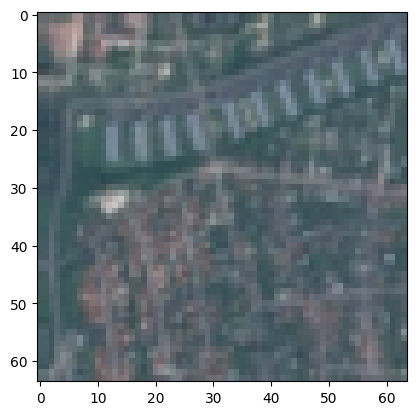

In [ ]:
# Check dataset imagery

# Choose a random image and display it
random_index = np.random.choice(len(images_array))
plt.imshow(images_array[random_index])

# Model Architecture
Following Chollet, the encoder and decoder architecture mirrors one another; both are CovNets using strides to downsample and upsample the images. ChatGPT suggested using Batch Normalization layers to stabilize the model's learning.

In [ ]:
#Based on Listing 12.24

encoder_inputs = keras.Input(shape=input_shape)
x = layers.Conv2D(
    32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
# Remembering shape before flattening for decoder
conv_shape = x.shape
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 2, 2, 512) │  1,180,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     32,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │      2,176 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │      2,176 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,609,552 (6.14 MB)

 Trainable params: 1,607,632 (6.13 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
#Based on Listing 12.26
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation="relu")(latent_inputs)
x = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = layers.Conv2DTranspose(512, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2D(num_channels, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 512)      │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,196,035 (16.01 MB)

 Trainable params: 4,194,051 (16.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

# Sampler and VAE Classes
Again following Chollet, two classes are created. One is the sampler which randomly samples a point to decode. The other is the VAE model class itself which contains functions for returning metrics, for the predict method, the training step, and a callback for linear KLD annealing.

In [ ]:
#Listing 12.25
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
#Based on Listing 12.27

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        # KL Annealing parameters
        self.kl_weight = 0.0
        # Increase per epoch
        self.kl_anneal_rate = 1.0 / epoch_num

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
                ]

    def call(self, inputs):
        # Encoder part: Get z_mean and z_log_var
        z_mean, z_log_var = self.encoder(inputs)

        # Sampling: Reparameterization trick
        z = self.sampler(z_mean, z_log_var)

        # Decoder part: Reconstruct the input from z
        reconstruction = self.decoder(z)

        return reconstruction

    def train_step(self, data):

        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = self.decoder(z)

            mse = keras.losses.MeanSquaredError(reduction='none')
            loss_per_pixel = mse(data, reconstruction)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(loss_per_pixel, axis=[1,2]))

            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            kl_loss = tf.reduce_mean(kl_loss)

            total_loss = reconstruction_loss + self.kl_weight * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    # https://keras.io/guides/writing_your_own_callbacks/
    def on_epoch_end(self, epoch, logs=None):
        # Update kl_weight every epoch
        self.kl_weight = min(1.0, self.kl_weight + self.kl_anneal_rate)
        print(f"KL Weight: {self.kl_weight:.4f}")

# Running the Model and Visualizing Its Reconstructions
Finally we run the model, getting a total loss around 30. Visualizing the images we see this loss is not ideal, but I am a "loss" for how to improve the results. It seems that the issue may lie with the dataset imagery itself, which may have too much detail and variation when compared with faces (*celeb_a* dataset) or numerals (*MNIST* dataset). Still, it can detect color and brightness values in the correct location.

In [ ]:
#Listing 12.28

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), run_eagerly=False)
history = vae.fit(images_array, epochs=epoch_num, batch_size=batch_size)

Epoch 1/80
165/165 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - kl_loss: 0.1354 - reconstruction_loss: 129.5124 - total_loss: 129.5124
Epoch 2/80
165/165 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - kl_loss: 12.3766 - reconstruction_loss: 100.9667 - total_loss: 100.9667
Epoch 3/80
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - kl_loss: 302.9246 - reconstruction_loss: 68.4224 - total_loss: 68.4224
Epoch 4/80
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - kl_loss: 489.2679 - reconstruction_loss: 61.7636 - total_loss: 61.7636
Epoch 5/80
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - kl_loss: 456.5977 - reconstruction_loss: 58.9698 - total_loss: 58.9698
Epoch 6/80
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - kl_loss: 402.2359 - reconstruction_loss: 57.6353 - total_loss: 57.6353
Epoch 7/80
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - kl_loss: 384.8496 - reconstruction_loss: 56.8631 - total_loss: 56.8631
Epoch 8/80
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - kl_loss: 401.3861 - reconstruction_loss: 56.2159 - to

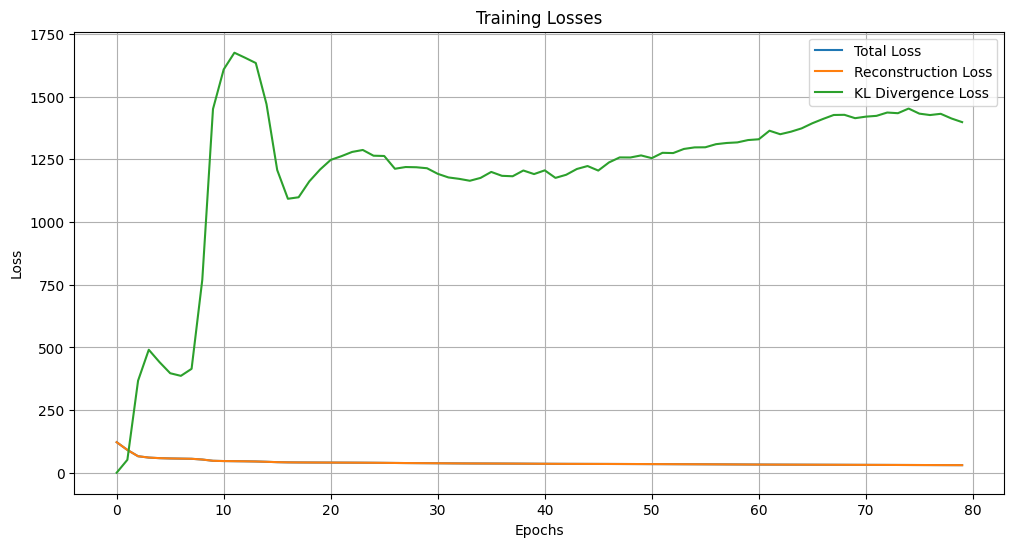

In [ ]:
# Plotting losses
plt.figure(figsize=(12, 6))

# Plot total loss
plt.plot(history.history['total_loss'], label='Total Loss')

# Plot reconstruction loss
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')

# Plot KL divergence loss
plt.plot(history.history['kl_loss'], label='KL Divergence Loss')

# If you tracked kl_weight, you can plot it too (optional)
if 'kl_weight' in history.history:
    plt.plot(history.history['kl_weight'], label='KL Weight')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


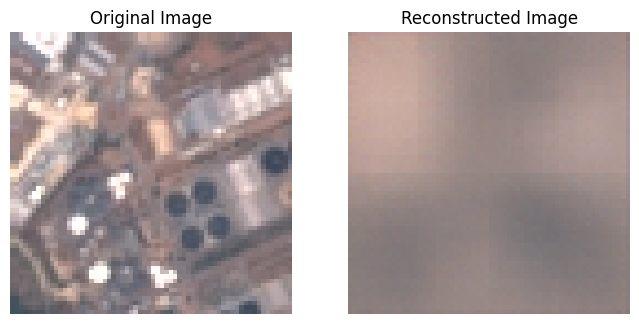

In [ ]:
# Choose a test image
random_index = np.random.choice(len(images_array))
input_image = images_array[random_index]

# Reshape the image to have a batch dimension of 1, since the model expects a batch of images
input_image = np.expand_dims(input_image, axis=0)

# Get the reconstructed image from the VAE model
reconstructed_image = vae.predict(input_image)

# Plotting the original vs reconstructed image
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(input_image[0])  # The input image is 1-dimensional after batch expansion
plt.title("Original Image")
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image[0])  # The reconstructed image will also be 1-dimensional
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()

# Exploring Latent Space
Even with the images' blurriness it is still possible to see the interpolation of space happening between two source images. Neat!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


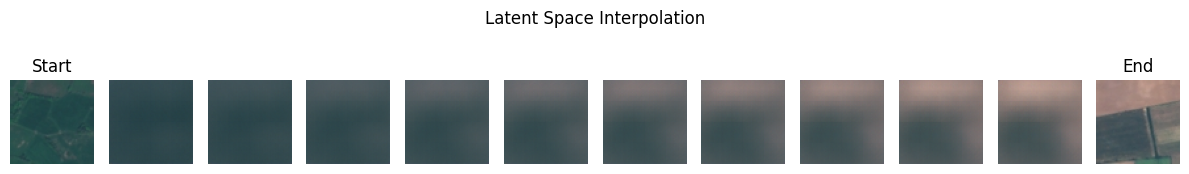

In [ ]:
def interpolate_latent_space(encoder, decoder, img1, img2, steps=10):
    """
    Interpolates between two images in latent space and shows the interpolation.
    """
    # Encode both images to get their latent representations
    z_mean1, _ = encoder.predict(np.expand_dims(img1, axis=0))
    z_mean2, _ = encoder.predict(np.expand_dims(img2, axis=0))

    # Linearly interpolate in latent space
    interpolated = []
    for alpha in np.linspace(0, 1, steps):
        z_interp = (1 - alpha) * z_mean1 + alpha * z_mean2
        x_decoded = decoder.predict(z_interp)
        interpolated.append(x_decoded[0])

    # Plot original and interpolated images
    plt.figure(figsize=(steps + 2, 2))

    # Original image 1
    plt.subplot(1, steps + 2, 1)
    plt.imshow(img1)
    plt.title("Start")
    plt.axis('off')

    # Interpolated images
    for i, img in enumerate(interpolated):
        plt.subplot(1, steps + 2, i + 2)
        plt.imshow(img)
        plt.axis('off')

    # Original image 2
    plt.subplot(1, steps + 2, steps + 2)
    plt.imshow(img2)
    plt.title("End")
    plt.axis('off')

    plt.suptitle("Latent Space Interpolation")
    plt.tight_layout()
    plt.show()

# Pick two random images from your normalized dataset
img1 = images_array[np.random.randint(len(images_array))]
img2 = images_array[np.random.randint(len(images_array))]

interpolate_latent_space(encoder, decoder, img1, img2, steps=10)